In [204]:
# @title
import time
!pip install feedparser
import feedparser
import requests
import pandas as pd
import networkx as nx
import math
import re
import json
from collections import defaultdict, Counter
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import community as community_louvain

In [266]:
# @title
QUERY = 'all:"artificial intelligence"'
NUM_PAPERS = 500
SLEEP_BETWEEN_REQUESTS = 3.0
TOP_K_KEYWORDS = 10
MIN_KEYWORD_DOC_FREQ = 1

STOPWORDS = set(stopwords.words('english'))

STOPWORDS.add('conference')
STOPWORDS.add('would')
STOPWORDS.add('also')
STOPWORDS.add('ai')
ORDINAL_WORDS = {
    'first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
    'eleventh', 'twelfth', 'thirteenth', 'fourteenth', 'fifteenth', 'sixteenth', 'seventeenth',
    'eighteenth', 'nineteenth', 'twentieth', 'thirtieth', 'fortieth', 'fiftieth', 'sixtieth',
    'seventieth', 'eightieth', 'ninetieth'
}
NUMBERS_1_TO_100 = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
    'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy',
    'eighty', 'ninety', 'twenty-one', 'twenty-two', 'twenty-three', 'twenty-four',
    'twenty-five', 'twenty-six', 'twenty-seven', 'twenty-eight', 'twenty-nine',
    'thirty-one', 'thirty-two', 'thirty-three', 'thirty-four', 'thirty-five',
    'thirty-six', 'thirty-seven', 'thirty-eight', 'thirty-nine', 'forty-one',
    'forty-two', 'forty-three', 'forty-four', 'forty-five', 'forty-six', 'forty-seven',
    'forty-eight', 'forty-nine', 'fifty-one', 'fifty-two', 'fifty-three', 'fifty-four',
    'fifty-five', 'fifty-six', 'fifty-seven', 'fifty-eight', 'fifty-nine', 'sixty-one',
    'sixty-two', 'sixty-three', 'sixty-four', 'sixty-five', 'sixty-six', 'sixty-seven',
    'sixty-eight', 'sixty-nine', 'seventy-one', 'seventy-two', 'seventy-three', 'seventy-four',
    'seventy-five', 'seventy-six', 'seventy-seven', 'seventy-eight', 'seventy-nine', 'eighty-one',
    'eighty-two', 'eighty-three', 'eighty-four', 'eighty-five', 'eighty-six', 'eighty-seven',
    'eighty-eight', 'eighty-nine', 'ninety-one', 'ninety-two', 'ninety-three', 'ninety-four',
    'ninety-five', 'ninety-six', 'ninety-seven', 'ninety-eight', 'ninety-nine', 'hundred'
}
MONTHS = {
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december'
}

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\n',' ').strip()
    return text

def preprocess_for_keywords(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [t for t in text.split() if t not in STOPWORDS
              and t not in ORDINAL_WORDS
              and t not in NUMBERS_1_TO_100
              and t not in MONTHS
              and not re.fullmatch(r'\d{4}', t)
              and not re.fullmatch(r'\d{2}', t)
              and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

def fetch_arxiv(query=QUERY, num_papers=NUM_PAPERS, sleep_sec=SLEEP_BETWEEN_REQUESTS):
    base = 'http://export.arxiv.org/api/query?'
    results = []
    start = 0
    batch = 100
    pbar = tqdm(total=num_papers, desc="Fetching arXiv")
    while len(results) < num_papers:
        to_fetch = min(batch, num_papers - len(results))
        q = f'search_query={requests.utils.quote(query)}&start={start}&max_results={to_fetch}'
        url = base + q
        resp = requests.get(url, headers={'User-Agent': 'arXiv-ML-Keyword-Graph/0.1'})
        if resp.status_code != 200:
            raise RuntimeError(f"arXiv API returned {resp.status_code}")
        feed = feedparser.parse(resp.content)
        entries = feed.entries
        if not entries:
            break
        for e in entries:
            entry = {}
            entry['id'] = e.get('id')
            entry['title'] = clean_text(e.get('title',''))

            authors = []
            if 'authors' in e:
                authors = [a.name for a in e.authors]
            entry['authors'] = authors
            entry['summary'] = clean_text(e.get('summary',''))
            results.append(entry)
            pbar.update(1)
            if len(results) >= num_papers:
                break
        start += to_fetch
        time.sleep(sleep_sec)
    pbar.close()
    return results[:num_papers]

In [262]:
def extract_keywords(docs, top_k=TOP_K_KEYWORDS, ngram_range=(1,2)):
    corpus = []
    ids = []
    for d in docs:
        txt = (d['title'] + ' ' + d['summary']).strip()
        corpus.append(preprocess_for_keywords(txt))
        ids.append(d['id'])
    vectorizer = TfidfVectorizer(max_df=0.055, min_df=0.001, ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    keywords_per_doc = {}
    for i, doc_id in enumerate(ids):
        row = X[i].toarray().flatten()
        top_indices = row.argsort()[-top_k:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices if row[idx] > 0]
        keywords_per_doc[doc_id] = top_terms
    return keywords_per_doc


In [208]:
import matplotlib.pyplot as plt

In [209]:
# @title
def build_keyword_graph(keywords_per_doc, min_doc_freq=MIN_KEYWORD_DOC_FREQ):
    # фильтр на уникальные keywords
    doc_freq = Counter()
    for kws in keywords_per_doc.values():
        unique = set(kws)
        for k in unique:
            doc_freq[k] += 1

    #построение графа по отфильтрованным словам
    allowed = {k for k,v in doc_freq.items() if v >= min_doc_freq}
    G = nx.Graph()
    for paper, kws in keywords_per_doc.items():
        kws = [k for k in kws if k in allowed]
        for k in kws:
            if not G.has_node(k):
                G.add_node(k, doc_freq=doc_freq[k])
        for i in range(len(kws)):
            for j in range(i+1, len(kws)):
                a, b = kws[i], kws[j]
                if G.has_edge(a,b):
                    G[a][b]['weight'] += 1
                else:
                    G.add_edge(a,b, weight=1)
    return G


def cluster_keywords(G):
    partition = community_louvain.best_partition(G, weight='weight')

    modularity = community_louvain.modularity(partition, G, weight='weight')
    return partition, modularity

In [210]:
# @title
def visualize_keyword_graph(G, partition=None, title="Keyword Graph"):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.3, seed=42)

    if partition:
        colors = [partition.get(n, 0) for n in G.nodes()]
    else:
        colors = "skyblue"

    sizes = [10 + 0.5*G.nodes[n].get("doc_freq",1) for n in G.nodes()]
    weights = [0.1 + d["weight"]*0.07 for u,v,d in G.edges(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=plt.cm.Set2, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=weights, edge_color="gray", alpha=0.5)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [211]:
# @title
def compute_centralities(G):
    deg = nx.degree_centrality(G)
    between = nx.betweenness_centrality(G, weight='weight', normalized=True)
    try:
        eigen = nx.eigenvector_centrality_numpy(G, weight='weight')
    except Exception:
        eigen = nx.eigenvector_centrality(G, max_iter=200, weight='weight')
    clos = nx.closeness_centrality(G, distance=lambda u,v,edata: 1.0/edata.get('weight',1))

    df = pd.DataFrame({
        'node': list(G.nodes()),
        'degree': [deg.get(n,0) for n in G.nodes()],
        'betweenness': [between.get(n,0) for n in G.nodes()],
        'eigenvector': [eigen.get(n,0) for n in G.nodes()],
        'closeness': [clos.get(n,0) for n in G.nodes()],
    })
    return df

def sort_centralities(df, sortedBy = 'degree'):
    df = df.sort_values(by=sortedBy, ascending=False)
    return df

In [212]:
# @title
def build_publication_graph(keywords_per_doc):
    papers = list(keywords_per_doc.keys())
    paper_kw_sets = {p: set(keywords_per_doc[p]) for p in papers}
    P = nx.Graph()
    for p in papers:
        P.add_node(p)
    for i in range(len(papers)):
        for j in range(i+1, len(papers)):
            a, b = papers[i], papers[j]
            common = paper_kw_sets[a].intersection(paper_kw_sets[b])
            w = len(common)
            if w > 0:
                P.add_edge(a, b, weight=w)
    return P

def visualize_publication_graph(P, title="Publication Graph", max_nodes=100):
    plt.figure(figsize=(12, 10))

    pos = nx.spring_layout(P, k=0.5, seed=42)
    sizes = [20 + P.degree(n) for n in P.nodes()]
    weights = [0.1 + d["weight"]*0.1 for u,v,d in P.edges(data=True)]

    nx.draw_networkx_nodes(P, pos, node_size=sizes, node_color="lightblue", alpha=0.7)
    nx.draw_networkx_edges(P, pos, width=weights, edge_color="gray", alpha=0.5)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def find_similar_papers_by_neighbors(P, paper_id, k=10):
    if paper_id not in P:
        raise KeyError("paper_id not in graph")
    neighbors = []
    for nbr in P.neighbors(paper_id):
        w = P[paper_id][nbr].get('weight',1)
        neighbors.append((nbr, w))
    neighbors.sort(key=lambda x: x[1], reverse=True)
    return neighbors[:k]

def find_similar_papers_by_shortest_path(P, paper_id, k=10):
    if paper_id not in P:
        raise KeyError("paper_id not in graph")

    H = P.copy()
    for u,v,d in H.edges(data=True):
        w = d.get('weight',1)
        d['distance'] = 1.0 / w
    lengths = nx.single_source_dijkstra_path_length(H, paper_id, weight='distance')
    items = [(pid, dist) for pid,dist in lengths.items() if pid != paper_id]
    items.sort(key=lambda x: x[1])
    return items[:k]

In [267]:
# @title
papers = fetch_arxiv(query=QUERY, num_papers=NUM_PAPERS, sleep_sec=SLEEP_BETWEEN_REQUESTS)
df_papers = pd.DataFrame([{
'id': p['id'],
'title': p['title'],
'authors': '; '.join(p['authors']),
'summary': p['summary']
} for p in papers])
df_papers.to_csv("papers.csv", index=False)
with open("papers.json","w",encoding="utf-8") as f:
    json.dump(papers, f, ensure_ascii=False, indent=2)

Fetching arXiv:  80%|████████  | 400/500 [00:14<00:03, 28.27it/s]


In [268]:
kp = extract_keywords(papers, top_k=TOP_K_KEYWORDS)

print(kp[papers[0]['id']])
with open("keywords_per_paper.json","w",encoding="utf-8") as f:
    json.dump(kp, f, ensure_ascii=False, indent=2)

['physical artificial', 'physical', 'governance physical', 'governance', 'intelligence define', 'prove important', 'responsible intelligent', 'define responsible', 'important challenge', 'intelligence physical']


In [269]:
KG = build_keyword_graph(kp, min_doc_freq=MIN_KEYWORD_DOC_FREQ)
nx.write_gexf(KG, "keyword_graph.gexf")
print(f"nodes={KG.number_of_nodes()}, edges={KG.number_of_edges()}")

nodes=3187, edges=16581


In [270]:
partition, modularity = cluster_keywords(KG)
print(f"Modularity: {modularity:.4f}")

cluster_map = defaultdict(list)
for n,c in partition.items():
    cluster_map[c].append(n)

clusters_sorted = sorted(cluster_map.items(), key=lambda x: len(x[1]), reverse=True)
for cid, nodes in clusters_sorted[:10]:
    print(f"Cluster {cid}: size={len(nodes)} top keywords sample: {nodes[:10]}")

Modularity: 0.8893
Cluster 0: size=131 top keywords sample: ['physical artificial', 'physical', 'governance physical', 'governance', 'intelligence define', 'prove important', 'responsible intelligent', 'define responsible', 'important challenge', 'intelligence physical']
Cluster 28: size=125 top keywords sample: ['workshop', 'centered artificial', 'human centered', 'centered', 'understand', 'intelligence machine', 'broken aspect', 'must designed', 'algorithm must', 'argue issue']
Cluster 24: size=114 top keywords sample: ['require progress', 'across computer', 'progress across', 'intelligence require', 'computer science', 'advance artificial', 'require', 'across', 'progress', 'science advance']
Cluster 26: size=109 top keywords sample: ['aaai workshop', 'game simulation', 'workshop game', 'game', 'simulation', 'http www', 'accepted submission', 'action selection', 'selection', 'action']
Cluster 27: size=100 top keywords sample: ['simulation artificial', 'metadata', 'academic', 'advocat

Можно наблюдать выделение нескольких крупных "темовых кластеров":

Физические и этические аспекты ИИ

Человеко-ориентированный ИИ и дизайн алгоритмов

Прогресс и развитие в области компьютерных наук и ИИ

Игровые симуляции и исследования в области ИИ

Академические исследования, метаданные и симуляции в ИИ

Манипуляции на рынке и применение ИИ в финансах

Будущее рынка труда и взаимодействие человека с ИИ

Монреаль Канада, небольшой ресерч показал, что это один из ведущих хабов ИИ

Ответственный ИИ и управление цепочками поставок

Цифровые технологии и коммуникации с использованием ИИ

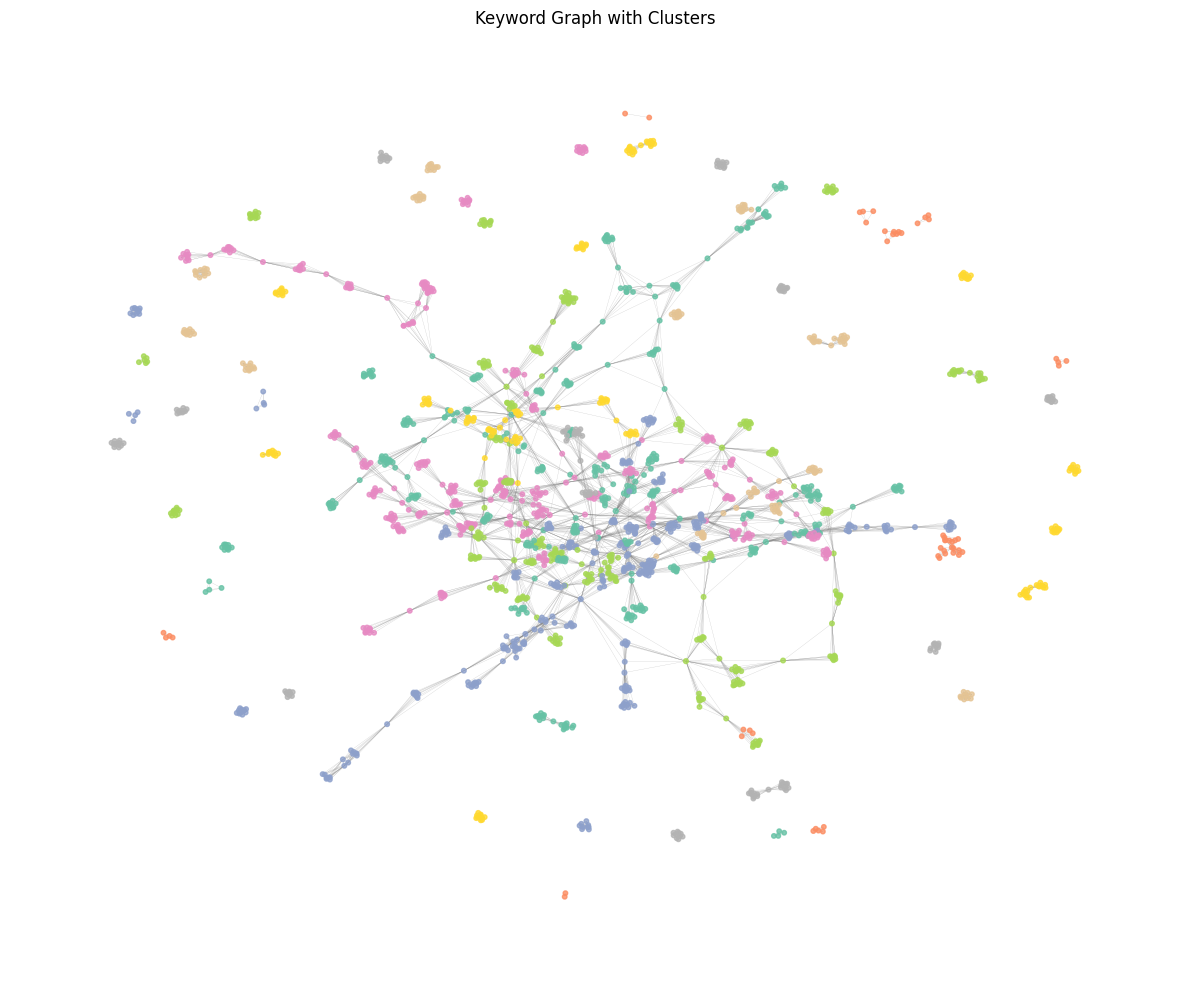

In [261]:
visualize_keyword_graph(KG, partition, title="Keyword Graph with Clusters")

In [218]:
cent_df = compute_centralities(KG)

In [219]:
cent_df = sort_centralities(cent_df,'degree')
print(cent_df[['node','degree']].head(10))

            node    degree
195       system  0.165650
43         human  0.150407
71         model  0.144309
290  application  0.107724
245         data  0.107724
226     learning  0.100610
70    technology  0.098577
8    intelligent  0.097561
64       machine  0.095528
67      research  0.094512


In [220]:
cent_df = sort_centralities(cent_df,'betweenness')
print(cent_df[['node','betweenness']].head(10))

            node  betweenness
71         model     0.065142
43         human     0.062153
195       system     0.059397
245         data     0.036478
290  application     0.033948
67      research     0.031635
70    technology     0.027524
26         study     0.026362
226     learning     0.025425
117  development     0.025278


In [221]:
cent_df = sort_centralities(cent_df,'eigenvector')
print(cent_df[['node','eigenvector']].head(10))

                       node  eigenvector
32               proceeding     0.380745
35        intelligence held     0.378666
33              uncertainty     0.377190
34  intelligence proceeding     0.376707
31   uncertainty artificial     0.376707
30   proceeding uncertainty     0.376707
36                     held     0.349730
88                       ca     0.090645
92                       wa     0.056538
87                   canada     0.045322


In [222]:
cent_df = sort_centralities(cent_df,'closeness')
print(cent_df[['node','closeness']].head(10))

                    node  closeness
195               system   0.665709
43                 human   0.648465
8            intelligent   0.628604
71                 model   0.610574
226             learning   0.608000
64               machine   0.607638
290          application   0.601615
68      machine learning   0.595610
61             knowledge   0.592840
446  intelligence system   0.589880


In [223]:
cent_df.to_csv("keyword_centralities.csv", index=False)

In [224]:
PG = build_publication_graph(kp)
nx.write_gexf(PG, "publication_graph.gexf")
print(f"nodes={PG.number_of_nodes()}, edges={PG.number_of_edges()}")

sample_paper = list(kp.keys())[0]
print(sample_paper)
print(find_similar_papers_by_neighbors(PG, sample_paper, k=10))
print(find_similar_papers_by_shortest_path(PG, sample_paper, k=10))

nodes=250, edges=3642
http://arxiv.org/abs/2304.02924v1
[('http://arxiv.org/abs/1512.00977v1', 1), ('http://arxiv.org/abs/2209.09780v3', 1), ('http://arxiv.org/abs/2007.07710v1', 1), ('http://arxiv.org/abs/2110.05263v3', 1), ('http://arxiv.org/abs/1511.04326v1', 1), ('http://arxiv.org/abs/1703.10098v1', 1), ('http://arxiv.org/abs/1807.08195v1', 1), ('http://arxiv.org/abs/2305.08093v1', 1), ('http://arxiv.org/abs/2404.07211v1', 1), ('http://arxiv.org/abs/2507.05951v1', 1)]
[('http://arxiv.org/abs/1512.00977v1', 1.0), ('http://arxiv.org/abs/2209.09780v3', 1.0), ('http://arxiv.org/abs/2007.07710v1', 1.0), ('http://arxiv.org/abs/2110.05263v3', 1.0), ('http://arxiv.org/abs/1511.04326v1', 1.0), ('http://arxiv.org/abs/1703.10098v1', 1.0), ('http://arxiv.org/abs/1807.08195v1', 1.0), ('http://arxiv.org/abs/2305.08093v1', 1.0), ('http://arxiv.org/abs/2404.07211v1', 1.0), ('http://arxiv.org/abs/2507.05951v1', 1.0)]


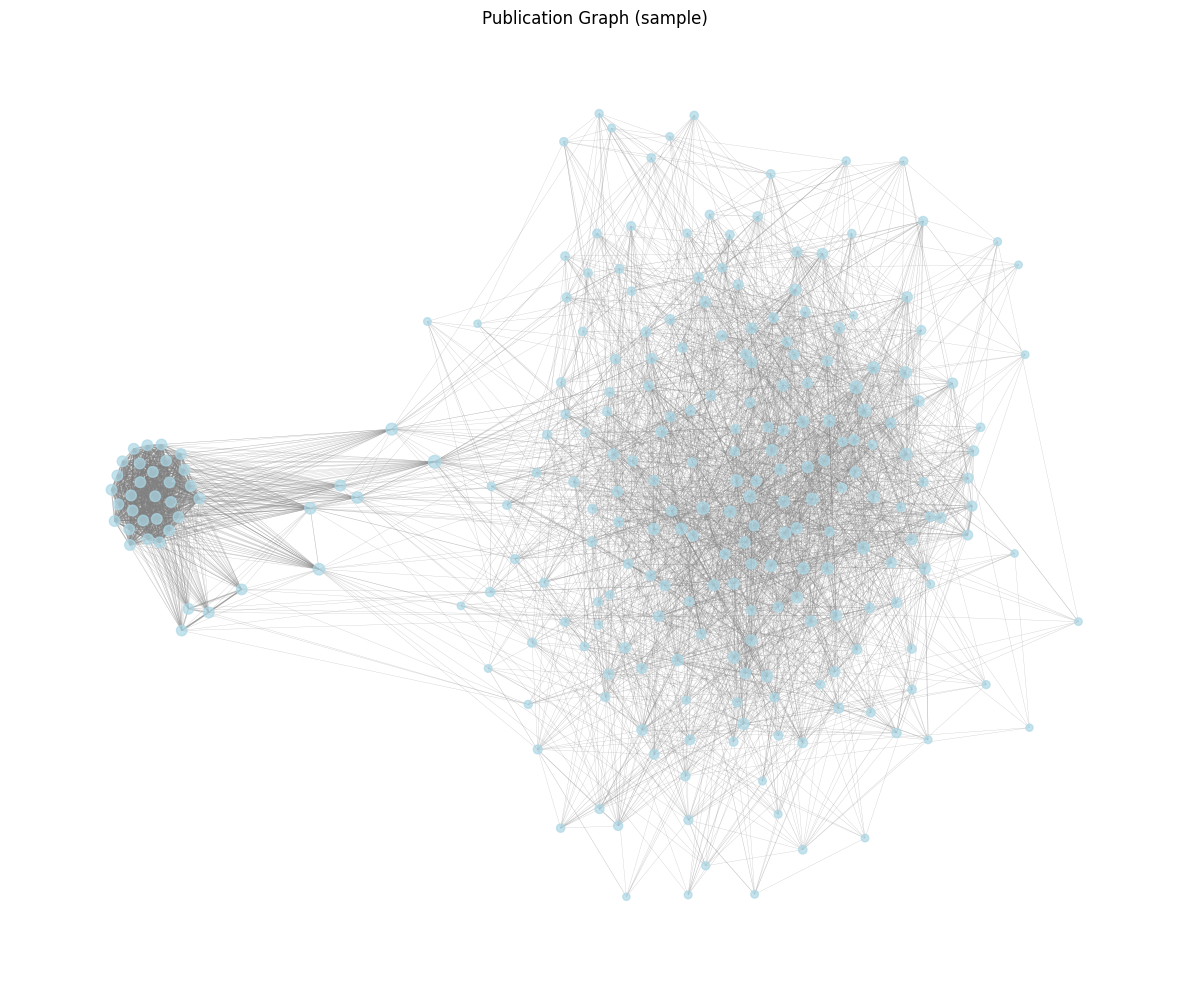

In [225]:
visualize_publication_graph(PG, title="Publication Graph (sample)")